In [2]:
%pip install mesa --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 3.2 MB/s eta 0:00:00


In [3]:
import mesa
print(mesa.__version__)

3.3.0


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# **Pregunta 1**

Modifique el codigo del Modelo Basado en Agentes que trabajamos en clase para
describir la dinamica de la propagacion de un chisme. El valor 1 en wealth significa que
el agente conoce el chisme, mientras que el valor 0 indica que no lo conoce.
Haga que, de manera aleatoria, solo el 10% de los agentes conozcan inicialmente el chisme.
Explique la implementacion de esta condicion inicial.
Modifique tambien la interaccion del agente, de tal forma que se exija que wealth sea 1
para buscar otro agente, e imponga que el agente encontrado quede con wealth = 1.
Realice un experimento con 20 agentes dados 12 pasos. Registre cuantos agentes conocen
el chisme en cada paso y grafique el resultado.

In [5]:
class GossipAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.wealth = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def spread_gossip(self):
        if self.wealth == 1:
            cellmates = self.model.grid.get_cell_list_contents([self.pos])
            cellmates.pop(cellmates.index(self))
            if len(cellmates) > 0:
                other = self.random.choice(cellmates)
                other.wealth = 1

class GossipModel(mesa.Model):
    def __init__(self, n, width, height):
        super().__init__()
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)
        agents = GossipAgent.create_agents(model=self, n=n)

        knows_rumor_agents = random.sample(agents, max(1, n // 10))
        for agent in knows_rumor_agents:
            agent.wealth = 1
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "RumorSpread": lambda m: sum([a.wealth for a in m.agents])
            },
            agent_reporters={"Wealth": "wealth"}
        )
    def step(self):
        self.agents.shuffle_do("move")
        self.agents.do("spread_gossip")
        self.datacollector.collect(self)

In [6]:
model = GossipModel(20, 10, 10)
for _ in range(12):
    model.step()

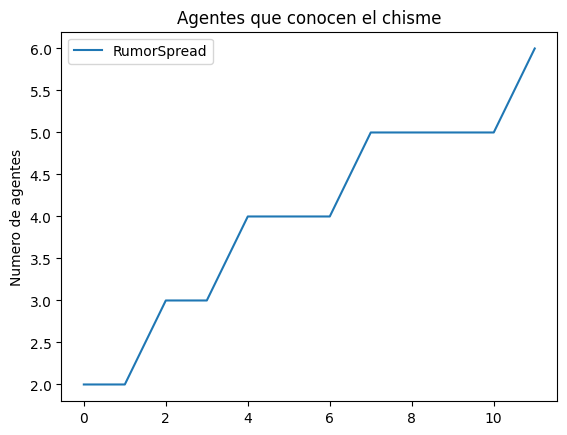

In [7]:
data = model.datacollector.get_model_vars_dataframe()
g = sns.lineplot(data = data)
g.set(title="Agentes que conocen el chisme", ylabel="Numero de agentes");

knows_rumor_agents = random.sample(agents, max(1, n // 10))
        for agent in knows_rumor_agents:
            agent.wealth = 1


Se esta recorriendo la variable de agents para elegir el 10% de los agentes, una condicion es que minimo se debe elegir 1 esto con el fin de que si los agentes son menores a 10 al menos 1 agente propague el chisme.

Despues se eligen en este caso los 2 agentes que se eligieron aleatoriamente para asignarle el valor de 1.

# **Pregunta 2**

- Cuente cuantas celdas estan vacıas en cada paso. Grafique el resultado.
- Use vecindarios de Von Neumann y observe si hay cambios en la dinamica.
- Haga que el movimiento dependa de la riqueza. Si un agente tiene wealth > 2 hay un 50% de posibilidad de que se quede en su lugar. ¿hay cambios en la dinamica del
sistema?


## Modelo sin filtro en el movimiento

In [73]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B

def compute_empty_cells(model):
    return sum(1 for cell_content, _ in model.grid.coord_iter() if len(cell_content) == 0)

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
      if self.wealth > 0 :
          cellmates = self.model.grid.get_cell_list_contents([self.pos])
         # Ensure agent is not giving money to itself
          cellmates.pop(cellmates.index(self))
          if len(cellmates) > 0:
            other = self.random.choice(cellmates)
            if other.wealth < 4:
              other.wealth += 1
              self.wealth -= 1


class MoneyModel_1(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height):
        super().__init__()
        self.num_agents = n
        # create the space
        self.grid = mesa.space.MultiGrid(width, height, True)
        # collect the output
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini,
                             "EmptyCells": compute_empty_cells}, agent_reporters={"Wealth": "wealth"}
        )

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [78]:
model_sin_filtro = MoneyModel_1(100, 10, 10)
for _ in range(100):
    model_sin_filtro.step()

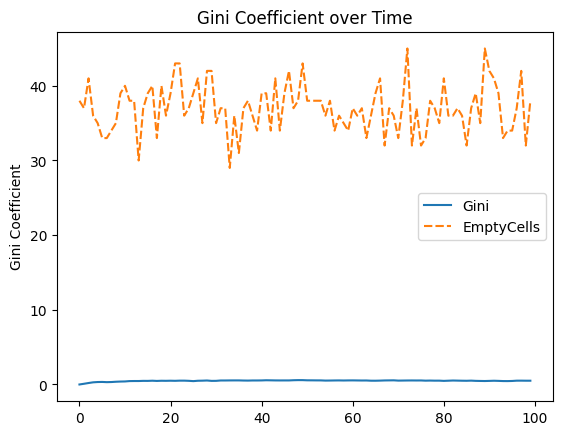

In [79]:
gini = model_sin_filtro.datacollector.get_model_vars_dataframe()
g = sns.lineplot(data = gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

## Modelo con filtro de Wealth > 2 en el movimiento

In [80]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B

def compute_empty_cells(model):
    return sum(1 for cell_content, _ in model.grid.coord_iter() if len(cell_content) == 0)

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        if self.wealth > 2 and self.random.random() < 0.5:
          return
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
      if self.wealth > 0 :
          cellmates = self.model.grid.get_cell_list_contents([self.pos])
         # Ensure agent is not giving money to itself
          cellmates.pop(cellmates.index(self))
          if len(cellmates) > 0:
            other = self.random.choice(cellmates)
            if other.wealth < 4:
              other.wealth += 1
              self.wealth -= 1


class MoneyModel_2(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height):
        super().__init__()
        self.num_agents = n
        # create the space
        self.grid = mesa.space.MultiGrid(width, height, True)
        # collect the output
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini,
                             "EmptyCells": compute_empty_cells}, agent_reporters={"Wealth": "wealth"}
        )

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [81]:
model_con_filtro = MoneyModel_2(100, 10, 10)
for _ in range(100):
    model_con_filtro.step()

[Text(0.5, 1.0, 'Comparación del Gini con y sin regla'),
 Text(0.5, 0, 'Tiempo'),
 Text(0, 0.5, 'Coeficiente de Gini')]

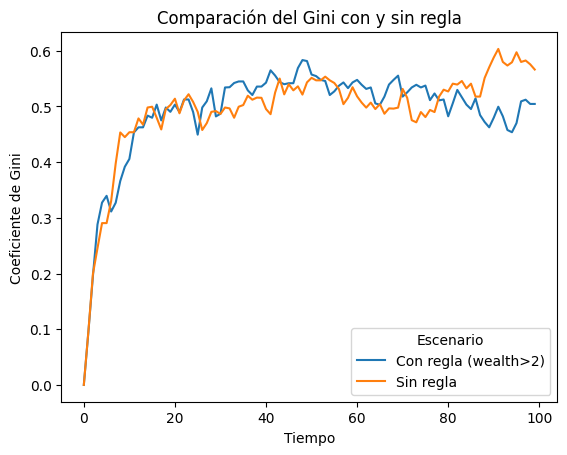

In [88]:
# Extraer resultados
gini_con_rule = model_sin_filtro.datacollector.get_model_vars_dataframe()
gini_con_rule["Escenario"] = "Con regla (wealth>2)"

gini_sin_rule = model_con_filtro.datacollector.get_model_vars_dataframe()
gini_sin_rule["Escenario"] = "Sin regla"

resultados = pd.concat([gini_con_rule, gini_sin_rule])

# Graficar el Gini
g = sns.lineplot(data=resultados, x=resultados.index, y="Gini", hue="Escenario")
g.set(title="Comparación del Gini con y sin regla",
      xlabel="Tiempo",
      ylabel="Coeficiente de Gini")


Cuando se aplica la regla de riqueza > 2 se empieza a notar que baja la desigualdad ya que los agentes que mas tienen riqueza circulan menos a comparacion del escenario donde no hay filtro, entre mas agentes interactuan mayor es la riqueza al inicio pero aumenta mas la desigualdad ya que se agentes acumulan mas riqueza.

## Neumann

In [93]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B

def compute_empty_cells(model):
    return sum(1 for cell_content, _ in model.grid.coord_iter() if len(cell_content) == 0)

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
      if self.wealth > 0 :
          cellmates = self.model.grid.get_cell_list_contents([self.pos])
         # Ensure agent is not giving money to itself
          cellmates.pop(cellmates.index(self))
          if len(cellmates) > 0:
            other = self.random.choice(cellmates)
            if other.wealth < 4:
              other.wealth += 1
              self.wealth -= 1


class MoneyModel_neumann(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height):
        super().__init__()
        self.num_agents = n
        # create the space
        self.grid = mesa.space.MultiGrid(width, height, True)
        # collect the output
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini,
                             "EmptyCells": compute_empty_cells}, agent_reporters={"Wealth": "wealth"}
        )

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [94]:
model_neumann = MoneyModel_neumann(100, 10, 10)
for _ in range(100):
    model_neumann.step()

     Gini  EmptyCells
0  0.0000          38
1  0.1486          33
2  0.1472          29
3  0.1978          33
4  0.2578          37


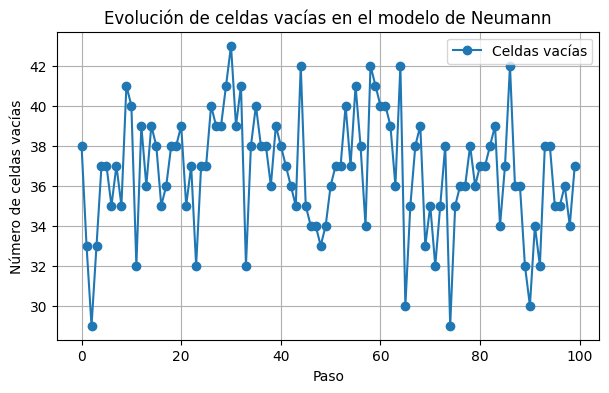

In [97]:
results = model_neumann.datacollector.get_model_vars_dataframe()
print(results.head())

plt.figure(figsize=(7,4))
plt.plot(results.index, results["EmptyCells"], marker="o", label="Celdas vacías")
plt.xlabel("Paso")
plt.ylabel("Número de celdas vacías")
plt.title("Evolución de celdas vacías en el modelo de Neumann")
plt.legend()
plt.grid(True)
plt.show()

## Moore

     Gini  EmptyCells
0  0.0000          38
1  0.0950          37
2  0.1958          41
3  0.2882          36
4  0.3274          35


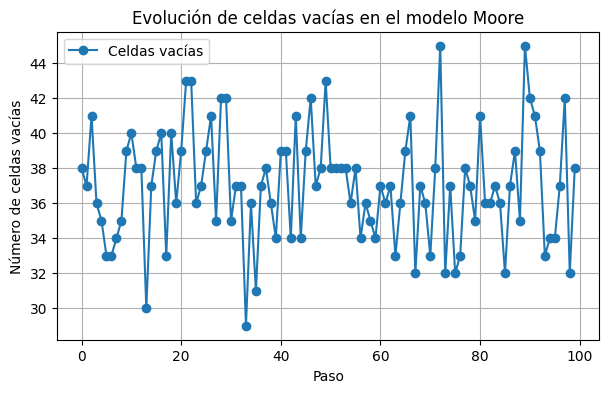

In [98]:
results = model_sin_filtro.datacollector.get_model_vars_dataframe()
print(results.head())

plt.figure(figsize=(7,4))
plt.plot(results.index, results["EmptyCells"], marker="o", label="Celdas vacías")
plt.xlabel("Paso")
plt.ylabel("Número de celdas vacías")
plt.title("Evolución de celdas vacías en el modelo Moore")
plt.legend()
plt.grid(True)
plt.show()

Cuando se utiliza la Vecindad de Von Neumann se evidencia que los agentes tienen menos espacio para moverse por lo que las celdas tienen mayor ocupacion a comparacion de Moore que los agentes tienen mas espacio y hay mayor celdas vacias

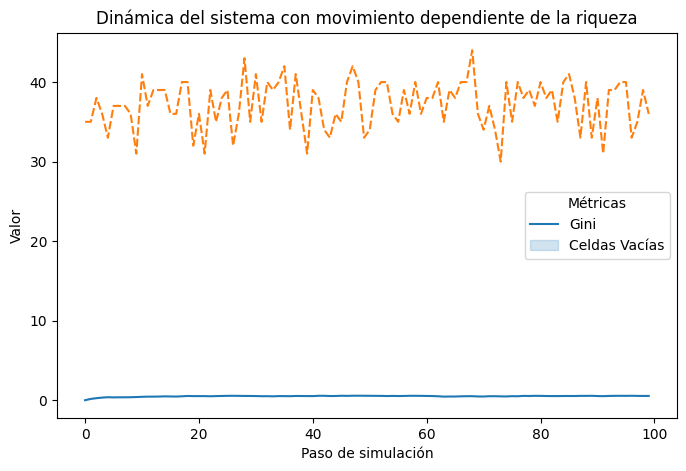

In [53]:
data = model.datacollector.get_model_vars_dataframe()
plt.figure(figsize=(8, 5))
g = sns.lineplot(data=data)
g.set(
    title="Dinámica del sistema con movimiento dependiente de la riqueza",
    xlabel="Paso de simulación",
    ylabel="Valor"
)
plt.legend(title="Métricas", labels=["Gini", "Celdas Vacías"])
plt.show()